# Module import

In [1]:
from netCDF4 import Dataset                             
import numpy as np                                      
from scipy import ndimage                               
import matplotlib.pyplot as plt           
import matplotlib.colors as mcolors              
from matplotlib.patches import Rectangle                
from scipy.ndimage import zoom
from skimage.transform import resize
import cartopy.crs as ccrs                              
import cartopy.feature as cfeature     
import cartopy.io.shapereader as shpreader
import sys
sys.path.insert(1, "../../module")
import snflics
import warnings
warnings.filterwarnings("ignore")

# Geodata

In [2]:
# lat and lon meshgrids
geodata = np.load("../../data/geodata/lat_lon_2268_2080.npz")
lons = geodata["lon"][:]
lats = geodata["lat"][:]

# Core data

In [3]:
year = '2019'
month = '02'
day = '15'
hour = '17'
minute = '00'

In [4]:
def load_wavelet_dataset(year, month, day, hour, minute):
    path_core = f'/gws/nopw/j04/cocoon/SSA_domain/ch9_wavelet/{year}/{month}'
    file = f'{path_core}/{year}{month}{day}{hour}{minute}.nc'
    return Dataset(file, mode='r')

In [5]:
data = load_wavelet_dataset(year, month, day, hour, minute)

# wavelet power maxima's coordinates
x0_lat = data["max_lat"][:]
x0_lon = data["max_lon"][:]

# cloud top temperature and wavelet power arrays
temp = data["tir"][0, :, :]
cores = data["cores"][0, :, :]
binary_cores = (cores != 0).astype(int)

In [6]:
locations = {
    "Lusaka": [-15.3875, 28.3228],
    "Ndola": [-12.9683, 28.6366],
    "Kasama": [-10.2129, 31.1808],
    "Chinsali": [-10.5500, 32.0667],
    "Kabwe": [-14.4469, 28.4464],
    "Livingstone": [-17.8419, 25.8542],
    "Mongu": [-15.2484, 23.1274],
    "Mansa": [-11.1996, 28.8943],
    "Solwezi": [-12.1722, 26.3981],
    "Chipata": [-13.6339, 32.6508]
}

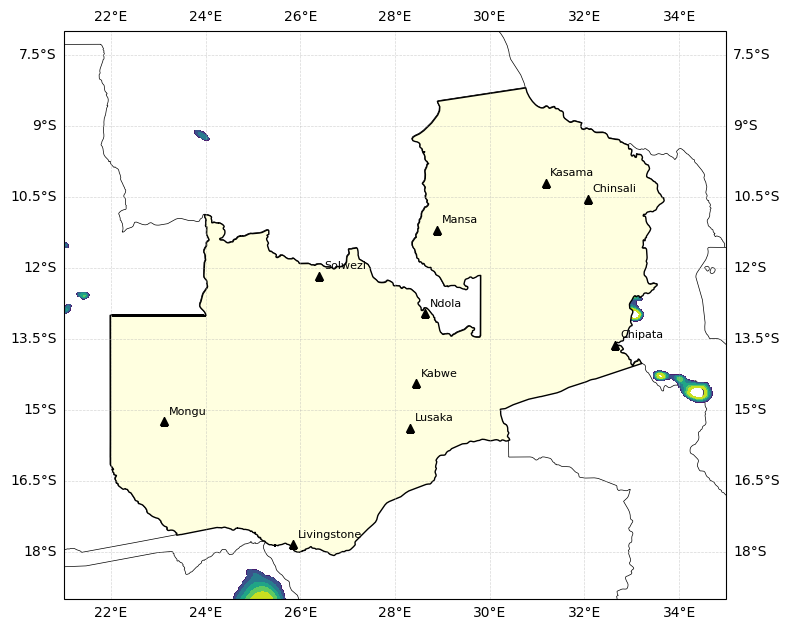

In [7]:
# Create figure and axis
fig = plt.figure(figsize=(8, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

# Set tight extent around Zambia
ax.set_extent([21, 35, -19, -7], crs=ccrs.PlateCarree())

# Base features
ax.add_feature(cfeature.LAND, facecolor='white', edgecolor='black', zorder=0)
ax.add_feature(cfeature.OCEAN, facecolor='lightblue', zorder=0)
ax.add_feature(cfeature.COASTLINE, edgecolor='black', linewidth=0.5, zorder=1)
ax.add_feature(cfeature.BORDERS, edgecolor='black', linewidth=0.5, zorder=1)

# Load Natural Earth country boundaries and extract Zambia only
shapename = 'admin_0_countries'
countries_shp = shpreader.natural_earth(resolution='10m',
                                        category='cultural', name=shapename)

for country in shpreader.Reader(countries_shp).records():
    if country.attributes['NAME'] == 'Zambia':
        ax.add_geometries([country.geometry], ccrs.PlateCarree(),
                          facecolor='lightyellow', edgecolor='black', linewidth=1.0, zorder=2)

# Your 10 locations
locations = {
    "Lusaka": [-15.3875, 28.3228],
    "Ndola": [-12.9683, 28.6366],
    "Kasama": [-10.2129, 31.1808],
    "Chinsali": [-10.5500, 32.0667],
    "Kabwe": [-14.4469, 28.4464],
    "Livingstone": [-17.8419, 25.8542],
    "Mongu": [-15.2484, 23.1274],
    "Mansa": [-11.1996, 28.8943],
    "Solwezi": [-12.1722, 26.3981],
    "Chipata": [-13.6339, 32.6508]
}

# Plot locations
for name, (lat, lon) in locations.items():
    ax.plot(lon, lat, marker="^", color="black", markersize=6, transform=ccrs.PlateCarree(), zorder=3)
    ax.text(lon + 0.1, lat + 0.1, name, fontsize=8, transform=ccrs.PlateCarree(), ha='left', va='bottom', color='black', zorder=4)

# Gridlines
gl = ax.gridlines(draw_labels=True, alpha=0.5, linestyle='--', linewidth=0.5)


contour_core = ax.contourf(lons, lats, cores, levels=[40, 80, 120, 160, 200, 240, 280], transform=ccrs.PlateCarree(), cmap="viridis")

plt.tight_layout()
plt.show()

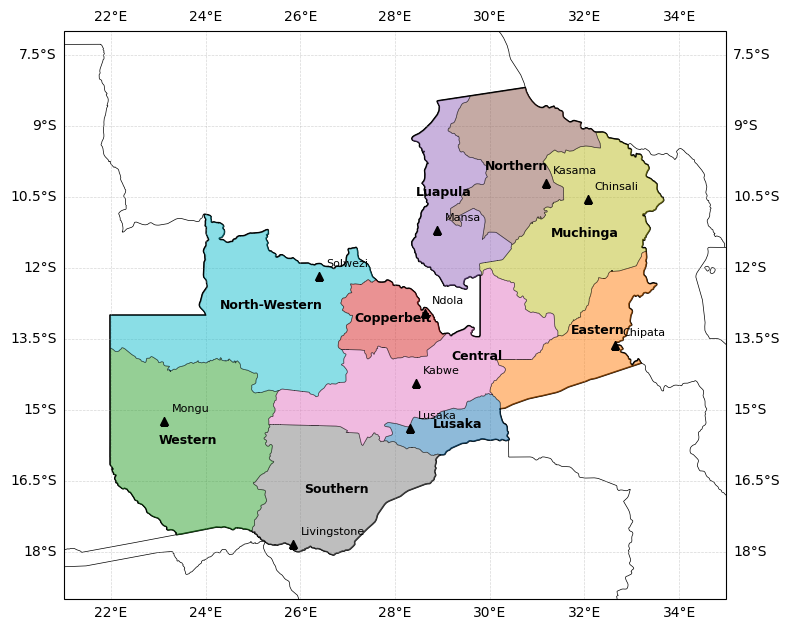

In [8]:
# Create figure and axis
fig = plt.figure(figsize=(8, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

# Set extent around Zambia
ax.set_extent([21, 35, -19, -7], crs=ccrs.PlateCarree())

# Add base map features
ax.add_feature(cfeature.LAND, facecolor='white', edgecolor='black', zorder=0)
ax.add_feature(cfeature.OCEAN, facecolor='lightblue', zorder=0)
ax.add_feature(cfeature.COASTLINE, edgecolor='black', linewidth=0.5, zorder=1)
ax.add_feature(cfeature.BORDERS, edgecolor='black', linewidth=0.5, zorder=1)

# Load Zambia country boundary
shapename_countries = 'admin_0_countries'
countries_shp = shpreader.natural_earth(resolution='10m', category='cultural', name=shapename_countries)

for country in shpreader.Reader(countries_shp).records():
    if country.attributes['NAME'] == 'Zambia':
        zambia_geom = country.geometry
        ax.add_geometries([zambia_geom], ccrs.PlateCarree(),
                          facecolor='none', edgecolor='black', linewidth=1.0, zorder=2)

# Load provinces (admin_1 polygons)
shapename_provinces = 'admin_1_states_provinces'
provinces_shp = shpreader.natural_earth(resolution='10m', category='cultural', name=shapename_provinces)

# Generate distinct colours for each province
colors = list(mcolors.TABLEAU_COLORS.values())
np.random.seed(42)
np.random.shuffle(colors)

i = 0  # color index

for province in shpreader.Reader(provinces_shp).records():
    if province.attributes['admin'] == 'Zambia':
        province_geom = province.geometry
        province_name = province.attributes['name']

        # Plot province polygon with color
        ax.add_geometries([province_geom], ccrs.PlateCarree(),
                          facecolor=colors[i % len(colors)], edgecolor='black', linewidth=0.5, alpha=0.5, zorder=3)

        # Calculate label location using representative point (always inside polygon)
        rep_point = province_geom.representative_point()
        ax.text(rep_point.x, rep_point.y, province_name, fontsize=9, weight='bold',
                ha='center', va='center', transform=ccrs.PlateCarree(), zorder=4)

        i += 1

# 10 locations
locations = {
    "Lusaka": [-15.3875, 28.3228],
    "Ndola": [-12.9683, 28.6366],
    "Kasama": [-10.2129, 31.1808],
    "Chinsali": [-10.5500, 32.0667],
    "Kabwe": [-14.4469, 28.4464],
    "Livingstone": [-17.8419, 25.8542],
    "Mongu": [-15.2484, 23.1274],
    "Mansa": [-11.1996, 28.8943],
    "Solwezi": [-12.1722, 26.3981],
    "Chipata": [-13.6339, 32.6508]
}

# Plot city locations
for name, (lat, lon) in locations.items():
    ax.plot(lon, lat, marker="^", color="black", markersize=6, transform=ccrs.PlateCarree(), zorder=5)
    ax.text(lon + 0.15, lat + 0.15, name, fontsize=8, transform=ccrs.PlateCarree(),
            ha='left', va='bottom', color='black', zorder=6)


# Gridlines
gl = ax.gridlines(draw_labels=True, alpha=0.5, linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()


In [21]:
ZAMBIA_TARGET_DOMAIN_LAT_MIN = -19
ZAMBIA_TARGET_DOMAIN_LAT_MAX = -7
ZAMBIA_TARGET_DOMAIN_LON_MIN = 21
ZAMBIA_TARGET_DOMAIN_LON_MAX = 35

y_min, x_min = snflics.to_yx(ZAMBIA_TARGET_DOMAIN_LAT_MIN, ZAMBIA_TARGET_DOMAIN_LON_MIN, lats, lons)
y_max, x_max = snflics.to_yx(ZAMBIA_TARGET_DOMAIN_LAT_MAX, ZAMBIA_TARGET_DOMAIN_LON_MAX, lats, lons)

zoomed_cores = cores[y_min:y_max+1, x_min:x_max+1]
zoomed_lats = lats[y_min:y_max+1, x_min:x_max+1]
zoomed_lons = lons[y_min:y_max+1, x_min:x_max+1]

In [22]:
print(y_min, y_max, x_min, x_max)

547 970 1436 1898


In [23]:
zoomed_cores.shape

(424, 463)

In [25]:
def resize_data(data, target_shape, order=1):
    """Resize a 2D data array using bilinear interpolation."""
    zoom_factors = (
        target_shape[0] / data.shape[0],
        target_shape[1] / data.shape[1],
    )
    return zoom(data, zoom=zoom_factors, order=order)

def resize_coords(lat_grid, lon_grid, target_shape):
    """Resize lat/lon coordinate grids using anti-aliasing."""
    lat_resized = resize(lat_grid, target_shape, mode='reflect', anti_aliasing=True)
    lon_resized = resize(lon_grid, target_shape, mode='reflect', anti_aliasing=True)
    return lat_resized, lon_resized

In [26]:
target_shape = target_shape=(68, 68)
resized_cores = resize_data(zoomed_cores, target_shape=target_shape)
resize_lats, resized_lons = resize_coords(zoomed_lats, zoomed_lons, target_shape=target_shape)

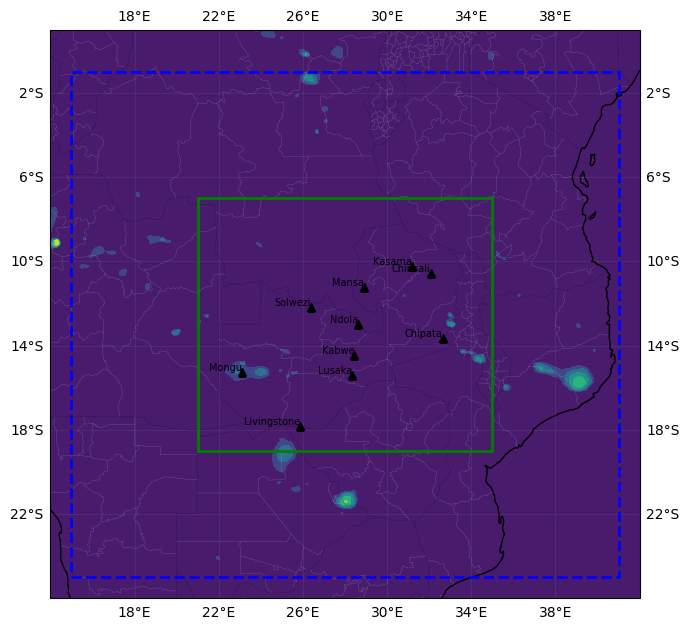

In [27]:
# Define extent
extent = (22-6-2, 34+6+2, -18-6-2, -9+6+2+2)

# Create figure and axis
fig, ax = plt.subplots(figsize=(7, 9), subplot_kw={'projection': ccrs.PlateCarree()})

# Force background to white
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

# Set map extent
ax.set_extent(extent, crs=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.BORDERS, edgecolor='black', linewidth=0.1)
ax.add_feature(cfeature.COASTLINE, edgecolor='black')

# Force LAND to be white
ax.add_feature(cfeature.LAND, facecolor='white', edgecolor='black')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')  # Optional


admin_borders = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='10m',
    facecolor='none'
    )

# Add administrative borders
admin_borders = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='10m',
    facecolor='none'
)
ax.add_feature(admin_borders, edgecolor='white', linewidth=0.07)

ZAMBIA_TARGET_DOMAIN_WIDTH = ZAMBIA_TARGET_DOMAIN_LON_MAX - ZAMBIA_TARGET_DOMAIN_LON_MIN
ZAMBIA_TARGET_DOMAIN_HEIGHT = ZAMBIA_TARGET_DOMAIN_LAT_MAX - ZAMBIA_TARGET_DOMAIN_LAT_MIN

ax.add_patch(Rectangle(
    (ZAMBIA_TARGET_DOMAIN_LON_MIN, ZAMBIA_TARGET_DOMAIN_LAT_MIN),
    ZAMBIA_TARGET_DOMAIN_WIDTH,
    ZAMBIA_TARGET_DOMAIN_HEIGHT,
    edgecolor='green',
    facecolor='none',
    linewidth=2,
    zorder=10
))

ZAMBIA_CONTEXT_DOMAIN_LAT_MIN = ZAMBIA_TARGET_DOMAIN_LAT_MIN - 6  # -25
ZAMBIA_CONTEXT_DOMAIN_LAT_MAX = ZAMBIA_TARGET_DOMAIN_LAT_MAX + 6  # -1
ZAMBIA_CONTEXT_DOMAIN_LON_MIN = ZAMBIA_TARGET_DOMAIN_LON_MIN - 6  # 15
ZAMBIA_CONTEXT_DOMAIN_LON_MAX = ZAMBIA_TARGET_DOMAIN_LON_MAX + 6  # 41


ZAMBIA_CONTEXT_DOMAIN_WIDTH = ZAMBIA_CONTEXT_DOMAIN_LON_MAX - ZAMBIA_CONTEXT_DOMAIN_LON_MIN
ZAMBIA_CONTEXT_DOMAIN_HEIGHT = ZAMBIA_CONTEXT_DOMAIN_LAT_MAX - ZAMBIA_CONTEXT_DOMAIN_LAT_MIN


ax.add_patch(Rectangle(
    (ZAMBIA_CONTEXT_DOMAIN_LON_MIN, ZAMBIA_CONTEXT_DOMAIN_LAT_MIN),
    ZAMBIA_CONTEXT_DOMAIN_WIDTH,
    ZAMBIA_CONTEXT_DOMAIN_HEIGHT,
    edgecolor='blue',
    facecolor='none',
    linewidth=2,
    linestyle='--',
    zorder=5
))


gl = ax.gridlines(xlocs=np.arange(14, 42, 4), 
                  ylocs=np.arange(-26, -1, 4), 
                  draw_labels=True, 
                  crs=ccrs.PlateCarree(),
                  alpha=0.1
                )

for name, (lat, lon) in locations.items():
  plt.plot(lon, lat, marker="^", color="black")
  ax.text(lon, lat, name, fontsize=7, transform=ccrs.PlateCarree(), ha='right', va='bottom', color='black', zorder=10)
  
contour_core = ax.contourf(lons, lats, cores, transform=ccrs.PlateCarree(), cmap="viridis")

plt.tight_layout()
plt.show()


In [38]:
import numpy as np

def haversine_distance(lat1, lon1, lat2, lon2):
    """Compute the great-circle distance (in km) between two lat/lon points."""
    R = 6371  # Earth radius in km
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    d_phi = np.radians(lat2 - lat1)
    d_lambda = np.radians(lon2 - lon1)

    a = np.sin(d_phi / 2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(d_lambda / 2)**2
    return 2 * R * np.arcsin(np.sqrt(a))

def generate_fictional_storm_zambia(city_lat=-13.0, city_lon=28.0):
    """
    Generate a fictional storm for Zambia, located outside the context domain
    and at least 500 km from its edge. Sampling is restricted to a ~500 km
    zone around the context domain (4.5° buffer).
    """

    # Zambia context domain (target domain + 6° in each direction)
    CONTEXT_LAT_MIN = -25
    CONTEXT_LAT_MAX = -1
    CONTEXT_LON_MIN = 15
    CONTEXT_LON_MAX = 41

    min_km_buffer = 500         # Required distance from context domain
    max_deg_buffer = 4.5        # Sampling range around context domain (~500 km)

    # Define sampling bounds
    lat_range = (CONTEXT_LAT_MIN - max_deg_buffer, CONTEXT_LAT_MAX + max_deg_buffer)
    lon_range = (CONTEXT_LON_MIN - max_deg_buffer, CONTEXT_LON_MAX + max_deg_buffer)

    while True:
        lat = np.random.uniform(*lat_range)
        lon = np.random.uniform(*lon_range)

        # Reject if inside context domain
        if CONTEXT_LAT_MIN <= lat <= CONTEXT_LAT_MAX and CONTEXT_LON_MIN <= lon <= CONTEXT_LON_MAX:
            continue

        # Compute distance to each edge of the context domain
        d_north = haversine_distance(lat, lon, CONTEXT_LAT_MAX, lon)
        d_south = haversine_distance(lat, lon, CONTEXT_LAT_MIN, lon)
        d_east  = haversine_distance(lat, lon, lat, CONTEXT_LON_MAX)
        d_west  = haversine_distance(lat, lon, lat, CONTEXT_LON_MIN)

        min_edge_dist = min(d_north, d_south, d_east, d_west)

        if min_edge_dist < min_km_buffer:
            continue

        distance_to_city = haversine_distance(lat, lon, city_lat, city_lon)
        return (0, {
            'lat': lat,
            'lon': lon,
            'wp': 0.0,
            'size': 0,
            'distance': distance_to_city,
            'mask': 0
        })


In [39]:
center_lon = 28.0
center_lat = -13.0 
generate_fictional_storm_zambia(center_lat, center_lon)

(0,
 {'lat': -29.498089607073698,
  'lon': 33.70936942421993,
  'wp': 0.0,
  'size': 0,
  'distance': np.float64(1926.6388891789973),
  'mask': 0})

In [40]:
def haversine_distance(lat1, lon1, lat2, lon2):
    """Compute the great-circle distance (in km) between two lat/lon points."""
    R = 6371  # Earth radius in km
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    d_phi = np.radians(lat2 - lat1)
    d_lambda = np.radians(lon2 - lon1)

    a = np.sin(d_phi / 2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(d_lambda / 2)**2
    return 2 * R * np.arcsin(np.sqrt(a))

def generate_fictional_storm(city_lat, city_lon,
                              context_lat_min, context_lat_max,
                              context_lon_min, context_lon_max,
                              min_km_buffer=500,
                              max_deg_buffer=4.5):
    """
    Generate a fictional storm at least `min_km_buffer` km from the context domain,
    but not farther than `max_deg_buffer` degrees away.

    Parameters:
        city_lat, city_lon: float
            Reference location (e.g. centre of target domain).
        context_lat_min, context_lat_max: float
            Latitude bounds of the context domain.
        context_lon_min, context_lon_max: float
            Longitude bounds of the context domain.
        min_km_buffer: float
            Minimum required distance from context domain edge.
        max_deg_buffer: float
            Maximum distance (in degrees) allowed from context edge for sampling.

    Returns:
        tuple: (0, dict with lat, lon, wp, size, distance, mask)
    """

    # Sampling range: context domain ± max_deg_buffer
    lat_range = (context_lat_min - max_deg_buffer, context_lat_max + max_deg_buffer)
    lon_range = (context_lon_min - max_deg_buffer, context_lon_max + max_deg_buffer)

    while True:
        lat = np.random.uniform(*lat_range)
        lon = np.random.uniform(*lon_range)

        # Reject if inside context domain
        if context_lat_min <= lat <= context_lat_max and context_lon_min <= lon <= context_lon_max:
            continue

        # Compute distance to each context edge
        d_north = haversine_distance(lat, lon, context_lat_max, lon)
        d_south = haversine_distance(lat, lon, context_lat_min, lon)
        d_east  = haversine_distance(lat, lon, lat, context_lon_max)
        d_west  = haversine_distance(lat, lon, lat, context_lon_min)

        min_edge_dist = min(d_north, d_south, d_east, d_west)

        if min_edge_dist < min_km_buffer:
            continue

        # Accept
        distance_to_city = haversine_distance(lat, lon, city_lat, city_lon)
        return (0, {
            'lat': lat,
            'lon': lon,
            'wp': 0.0,
            'size': 0,
            'distance': distance_to_city,
            'mask': 0
        })


In [41]:
generate_fictional_storm(
    center_lat, center_lon, 
    context_lat_min=ZAMBIA_CONTEXT_DOMAIN_LAT_MIN,
    context_lat_max=ZAMBIA_CONTEXT_DOMAIN_LAT_MAX,
    context_lon_min=ZAMBIA_CONTEXT_DOMAIN_LON_MIN,
    context_lon_max=ZAMBIA_CONTEXT_DOMAIN_LON_MAX
    )

(0,
 {'lat': 3.4982720621019894,
  'lon': 24.882186788585358,
  'wp': 0.0,
  'size': 0,
  'distance': np.float64(1866.548024503718),
  'mask': 0})

In [42]:
from scipy.ndimage import maximum_filter
import numpy as np

# Example binary grid (0s and 1s)
binary_grid = np.array([
    [0, 0, 1, 0, 0],
    [0, 1, 1, 1, 0],
    [0, 0, 0, 0, 0],
    [1, 0, 0, 0, 1],
    [0, 0, 0, 0, 0]
])

# Apply 5x5 maximum filter
filtered = maximum_filter(binary_grid, size=5, mode='constant', cval=0)

print(filtered)

[[1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]]
